The provided code outlines the initial steps of your data analysis process, focusing on centering the trajectories, interpolating them, and then transforming them using Fourier Descriptors. Let's break down these steps to understand their significance and implications for your analysis:

### Centering the Trajectories
- **Objective:** To reposition the trajectories so that their mean (average position) is at the origin. This step is crucial for ensuring that the analysis focuses on the shape of the trajectories, independent of their original positions in the sample space.
- **Method:** For each trajectory, the mean of the x and y coordinates is calculated, and these mean values are subtracted from each coordinate to center the trajectory.

### Interpolating the Trajectories
- **Objective:** To standardize the number of points across all trajectories. This is important because the trajectories might have been recorded at different sampling rates or durations.
- **Method:** Linear interpolation is used to resample each trajectory to a common length (specified by `num_points`, which is set to 50 in your code). This ensures uniformity in the number of data points for each trajectory, which is essential for consistent application of Fourier Descriptors.

### Fourier Descriptors Transformation
- **Objective:** To capture and represent the shape characteristics of each trajectory. Fourier Descriptors (FD) are a powerful tool for shape analysis as they are invariant to rotation, translation, and scale.
- **Method:** The Fourier Transform is applied separately to the x and y coordinates of the interpolated trajectories. The absolute values of these transforms are then combined to form the Fourier Descriptors. This transformation effectively captures the shape information of the trajectories, reducing the influence of noise and minor variations.

### Stacking Features
- Finally, the Fourier Descriptors for all trajectories are stacked into a numpy array, preparing the dataset for subsequent analysis, like PCA and clustering.

Your approach of preprocessing the data is meticulous and aligns well with the objectives of your study. The centered and interpolated trajectories, transformed via Fourier Descriptors, provide a robust foundation for the next steps of your analysis, ensuring that the focus is on the intrinsic shape characteristics of the spermatozoa trajectories. This preprocessing pipeline is crucial for the reliability and validity of your subsequent analyses and findings.

In [1]:
import pandas as pd

df = pd.read_pickle("df_reduced.pkl")
df.head()

,name,date,quantity,exposure,tracked_id,centered_traj,cluster_agg
0,balder,01062021-25,0,0.0,1.0,"[[-11.354838709677423, 2.516129032258064], [-1...",21
1,balder,01062021-25,0,0.0,3.0,"[[-32.243697478991606, -0.6134453781512619], [...",12
2,balder,01062021-25,0,0.0,4.0,"[[3.5581395348837077, 9.0], [3.558139534883707...",21
3,balder,01062021-25,0,0.0,6.0,"[[23.952941176470574, 1.7176470588235304], [22...",45
4,balder,01062021-25,0,0.0,7.0,"[[2.2413793103448256, -1.6896551724137936], [1...",11


In [2]:
import numpy as np
import pandas as pd
from numpy.fft import fft
from sklearn.cluster import KMeans
import ast

def fourier_descriptors(trajectory):
    # Assuming the trajectory is a list of [x, y] coordinates
    trajectory = np.array(trajectory)
    x = trajectory[:, 0]
    y = trajectory[:, 1]

    # Apply Fourier Transform
    fd_x = fft(x)
    fd_y = fft(y)

    # Combine the descriptors and return
    return np.concatenate([np.abs(fd_x), np.abs(fd_y)])

In [3]:
from scipy.interpolate import interp1d

def interpolate_trajectory(trajectory, num_points=50):
    # Assuming trajectory is a list of [x, y] coordinates
    trajectory = np.array(trajectory)
    x = trajectory[:, 0]
    y = trajectory[:, 1]

    # Create an interpolation function
    length = len(trajectory)
    f_x = interp1d(np.linspace(0, 1, length), x, kind='linear')
    f_y = interp1d(np.linspace(0, 1, length), y, kind='linear')

    # Interpolate to a common number of points
    new_x = f_x(np.linspace(0, 1, num_points))
    new_y = f_y(np.linspace(0, 1, num_points))

    return np.column_stack((new_x, new_y))

In [4]:
df['interpolated_traj'] = df['centered_traj'].apply(interpolate_trajectory)
df['fourier_descriptors'] = df['interpolated_traj'].apply(fourier_descriptors)

In [5]:
# Extracting the Fourier Descriptors as features for clustering
features = np.stack(df['fourier_descriptors'].values)

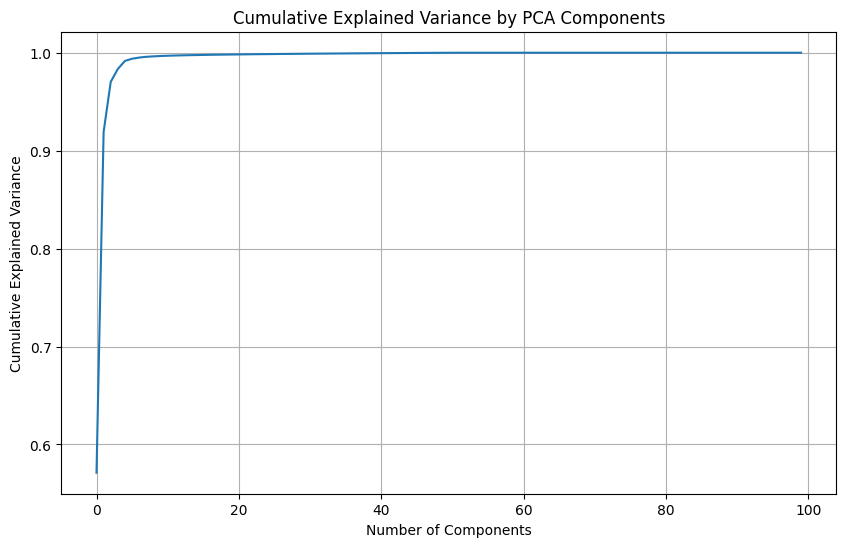

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Initialize PCA without specifying the number of components
pca = PCA()

# Fit PCA on the features
pca.fit(features)

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.show()

In [7]:
cumulative_explained_variance

array([0.57117838, 0.919174  , 0.97028937, 0.9834488 , 0.99163949,
       0.99385701, 0.99506354, 0.9958278 , 0.99628937, 0.99666489,
       0.99691911, 0.99714599, 0.99732439, 0.99748666, 0.9976242 ,
       0.99775219, 0.99786879, 0.99797537, 0.99807715, 0.99817223,
       0.99826473, 0.99835155, 0.99843322, 0.99851138, 0.99858779,
       0.99866079, 0.99873239, 0.99880348, 0.99886988, 0.99893516,
       0.99899869, 0.99906007, 0.9991196 , 0.999178  , 0.99923615,
       0.99929128, 0.99934584, 0.99939858, 0.99945095, 0.99950151,
       0.99955126, 0.99959984, 0.99964742, 0.99969369, 0.99973937,
       0.99978451, 0.99982809, 0.9998707 , 0.99991136, 0.99995095,
       0.99997871, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [6]:
from sklearn.decomposition import PCA

# Number of components to keep
n_components = 5# You can adjust this based on your needs

# Initialize PCA
pca = PCA(n_components=n_components)

# Fit PCA on features and transform the features
reduced_features = pca.fit_transform(features)

# Now you can use reduced_features for your clustering

Your approach to applying Principal Component Analysis (PCA) to the Fourier Descriptor features is a critical step in your data analysis process. Let's review and critique the methodology:

### PCA Application
1. **PCA Without Specifying the Number of Components:** Initially, you run PCA without specifying the number of components. This is a good strategy as it allows you to explore the data and understand how much variance each principal component explains.

2. **Cumulative Explained Variance Calculation:** By calculating the cumulative explained variance, you can determine how many components are needed to capture a significant portion of the information in the dataset. In your case, the first two components explain over 90% of the variance, which is substantial.

3. **Selecting Number of Components:** You've chosen to retain only the first two components. This decision should ideally be based on a balance between achieving a lower-dimensional representation and retaining enough variance to meaningfully represent the data. Given that the first two components explain over 90% of the variance, this seems like a reasonable choice. However, it's important to consider whether this level of variance is sufficient to capture the complex shapes of the trajectories, especially since higher-order components might contain subtle but biologically significant information.

### Critique and Suggestions
1. **Explained Variance Threshold:** While using two components seems reasonable in your case, it's important to set a clear threshold for the minimum cumulative explained variance considered acceptable. For some studies, a higher threshold (e.g., 95% or 99%) might be more appropriate.

2. **Biological Significance:** Ensure that the components retained are biologically meaningful. Sometimes, the mathematically significant components might not align with the biological significance. It may be worth examining some of the higher-order components to see if they capture any important aspects of the trajectories that the first two do not.

3. **Scree Plot Visualization:** Consider creating a scree plot of the variance explained by each principal component. This plot can provide a visual aid in deciding how many components to retain and can be a useful addition to your article.

4. **Data Reconstruction:** After reducing the dimensionality, it might be insightful to reconstruct some trajectories from the reduced features and compare them with the original trajectories. This can help assess how well the reduced features preserve the key characteristics of the trajectories.

5. **Sensitivity Analysis:** Perform a sensitivity analysis by varying the number of components retained and observing how it affects the subsequent clustering and ANOVA results. This can provide insights into the robustness of your findings.

Overall, your methodical approach to PCA is well-justified and aligns with standard practices in data analysis. However, ensuring the biological relevance of the selected components and considering the potential importance of higher-order components are critical for the validity and interpretability of your results.

In [7]:
from sklearn.cluster import SpectralClustering
import numpy as np

# Assuming reduced_feature is your PCA-reduced Fourier Descriptor feature matrix
# Example: reduced_feature = np.array([...])

# Specify the number of clusters
n_clusters = 5  # change this based on your needs

# Create the Spectral Clustering model
spectral_model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors')

# Fit the model to your data and predict cluster indices
cluster_labels = spectral_model.fit_predict(reduced_features)

# cluster_labels now contains the cluster index for each trajectory


In [8]:
df['Spectral Clustering'] = cluster_labels

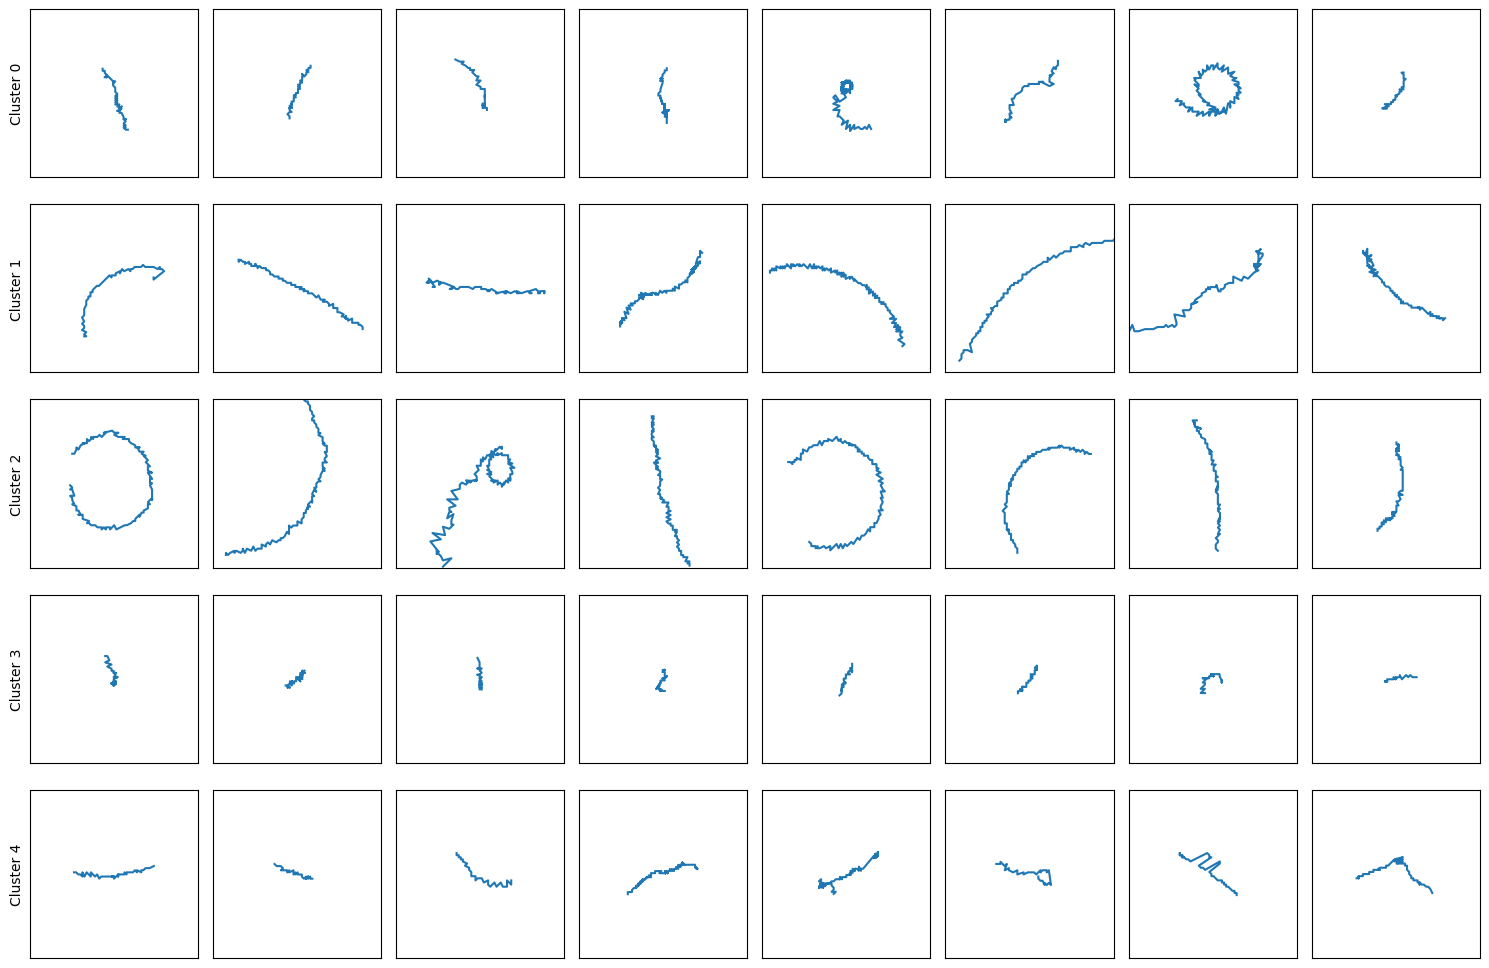

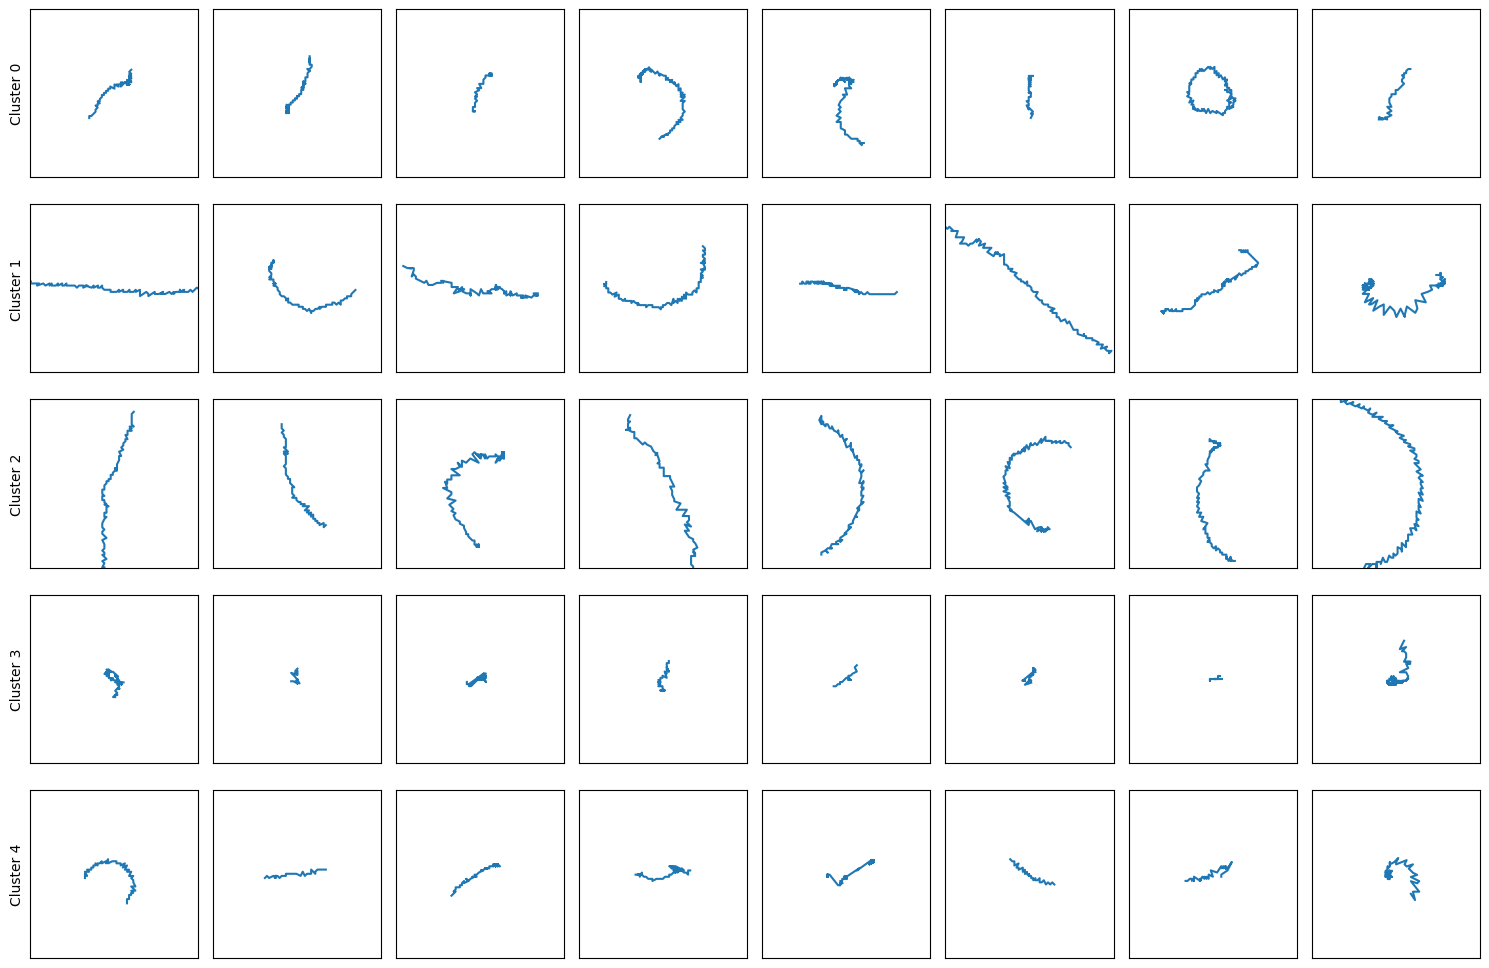

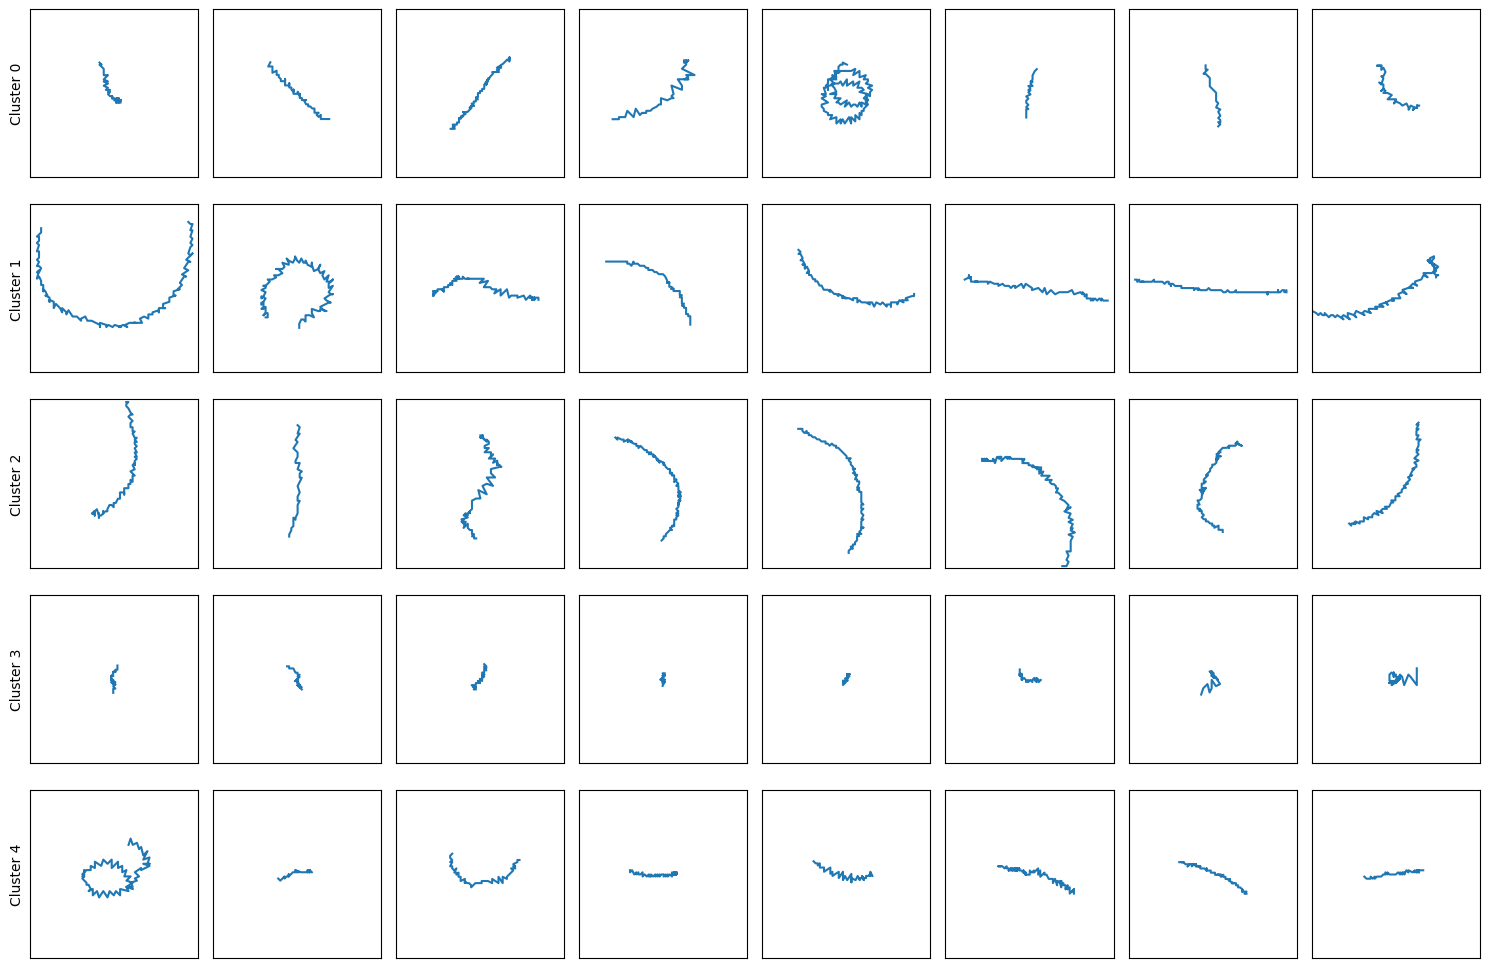

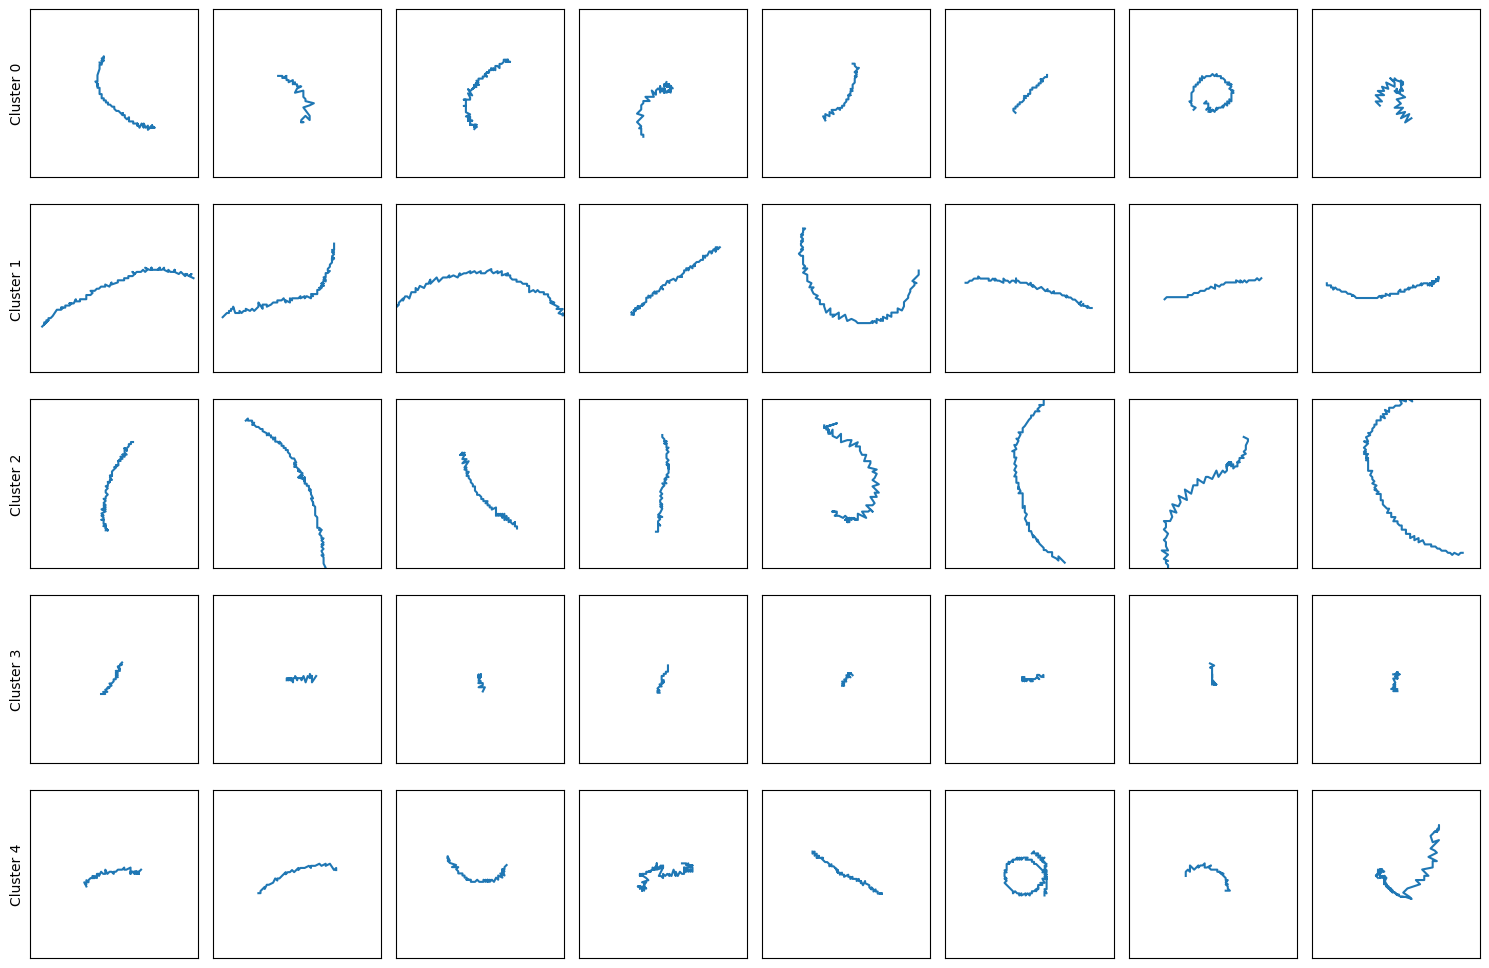

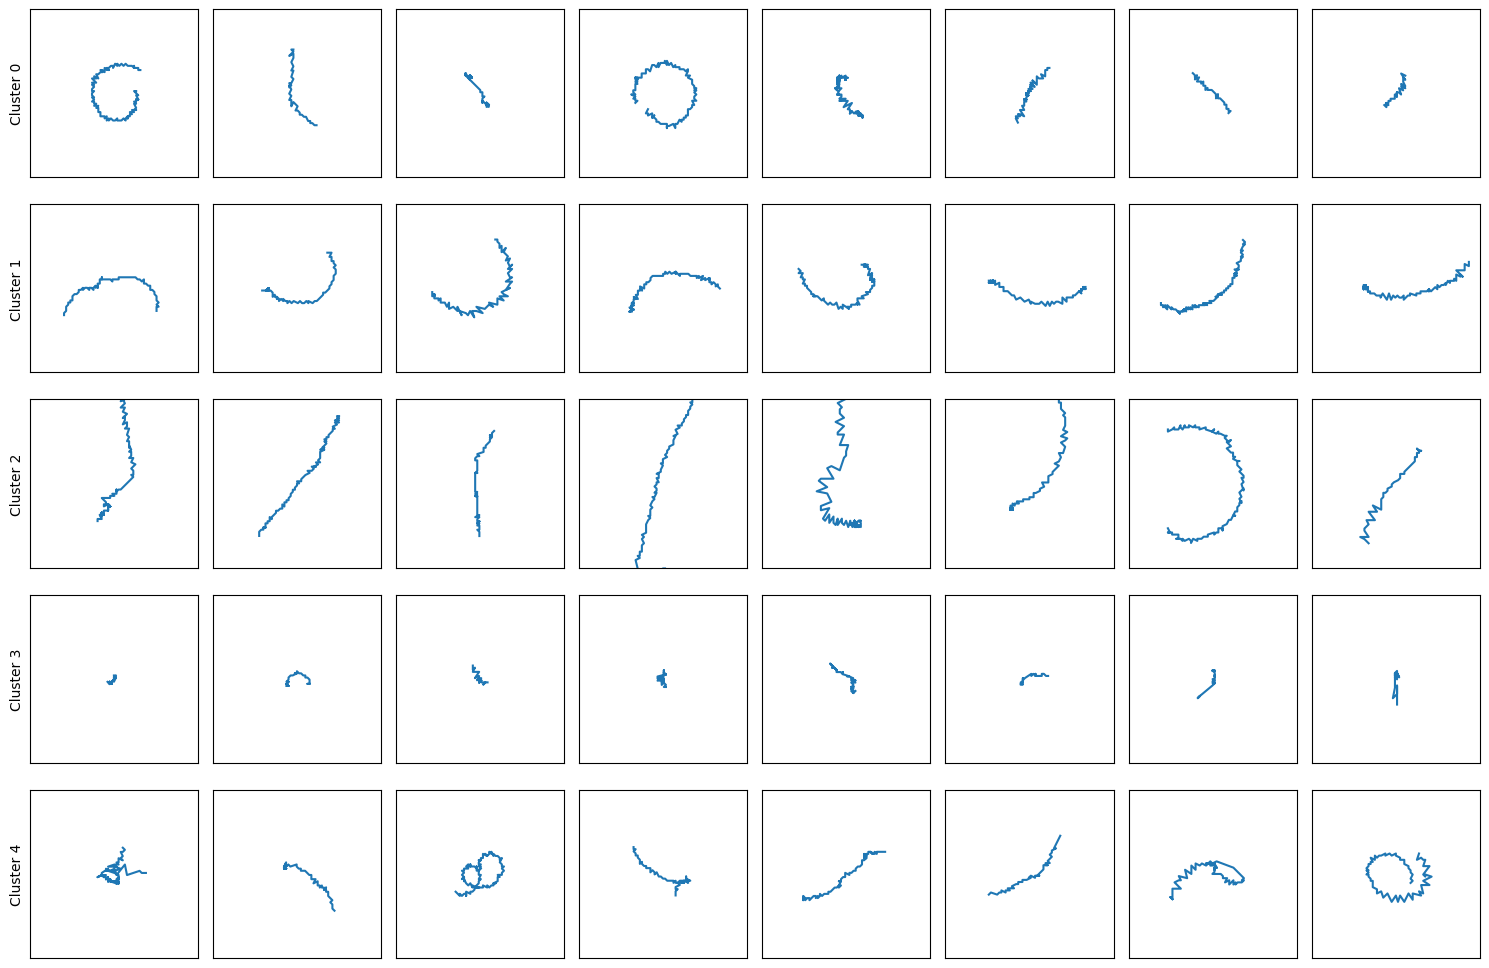

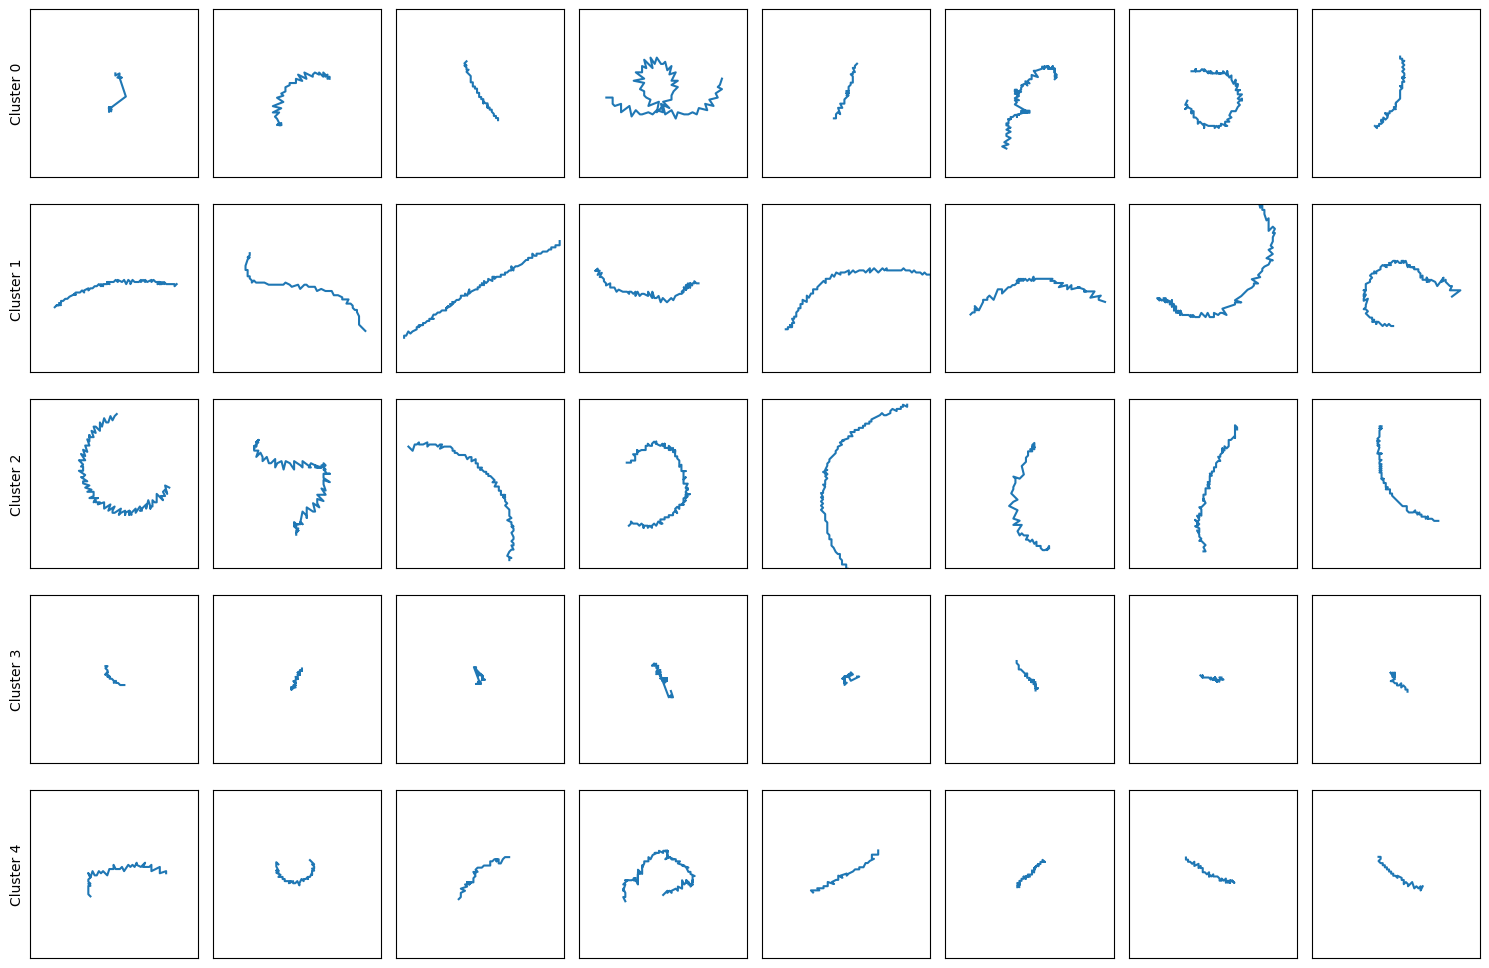

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast

# Number of clusters and samples per cluster
n_samples = 8
num_c = 5  # Number of clusters

# Create a figure with subplots
for fig_num in range(6):
    fig, axes = plt.subplots(num_c, n_samples, figsize=(15, 10))  # Adjust the size as needed
    for i in range(num_c):
        # Select random samples from each cluster
        cluster_data = df[df['Spectral Clustering'] == i].sample(n=n_samples, random_state=42+fig_num)
        
        for sample_num, (index, row) in enumerate(cluster_data.iterrows()):
            ax = axes[i][sample_num]
            # Extract the centered trajectory
            traj_array = np.array(row['centered_traj'])
            # Plot the trajectory
            ax.plot(traj_array[:, 0], traj_array[:, 1])

            ax.set_xlim(-40, 40)
            ax.set_ylim(-40, 40)
            ax.set_aspect('equal', adjustable='box')

            # Optional: Hide x and y axis labels for clarity
            ax.set_xticks([])
            ax.set_yticks([])

        # Set y-axis label for each row
        axes[i][0].set_ylabel(f"Cluster {i}")

    # Optional: adjust layout for better spacing
    plt.tight_layout()
    plt.show()


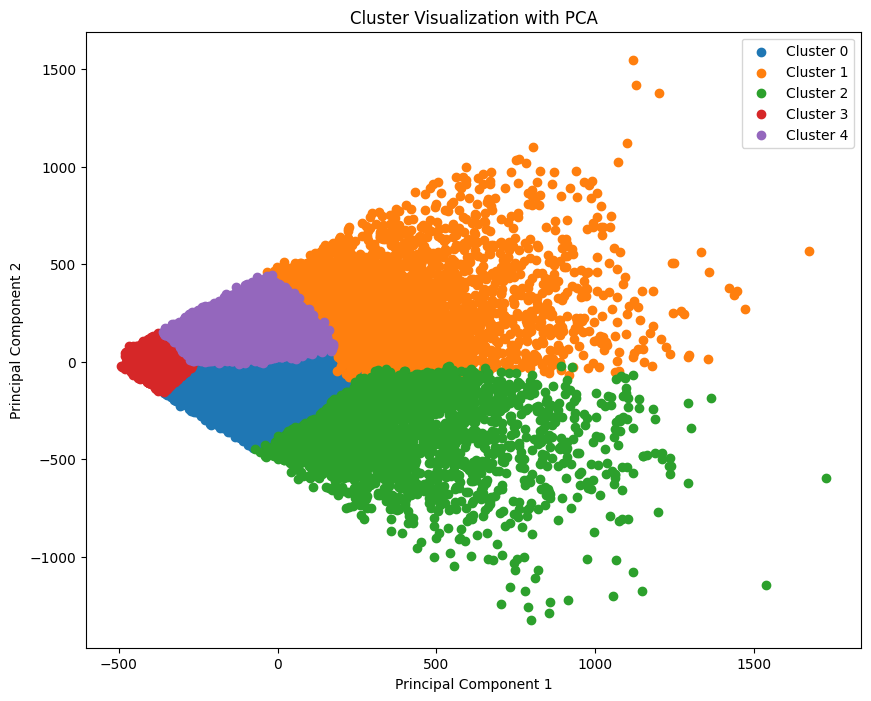

In [10]:


# Plot
plt.figure(figsize=(10, 8))
for cluster in range(num_c):  # Assuming there are 4 clusters
    cluster_data = reduced_features[df['Spectral Clustering'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}')

plt.title('Cluster Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


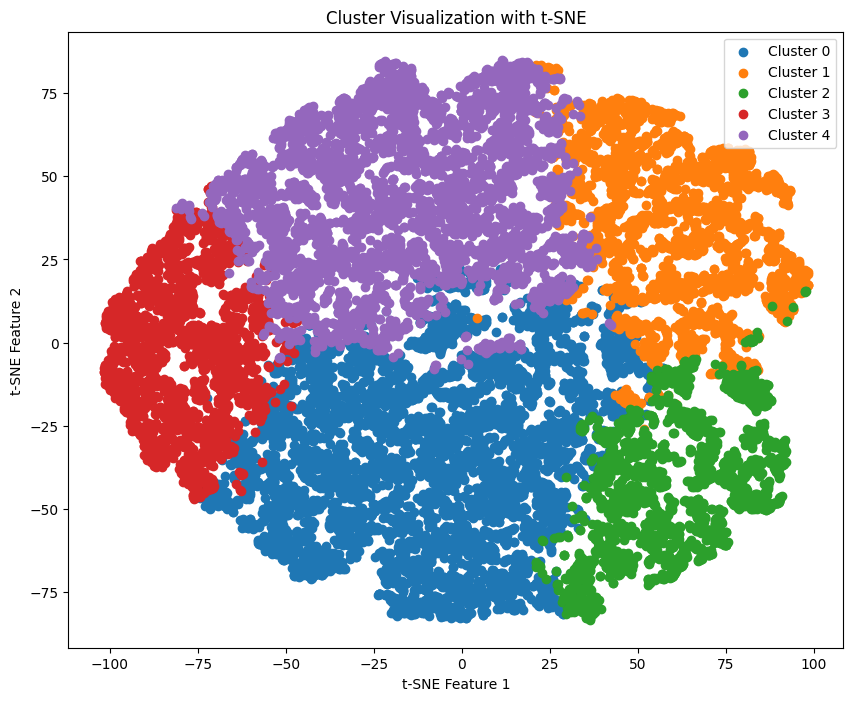

In [11]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming 'features' are your motility parameters
# Perform t-SNE to reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)  # random_state for reproducibility
reduced_features = tsne.fit_transform(features)

# Plot
plt.figure(figsize=(10, 8))
for cluster in range(num_c):  # Assuming there are 4 clusters
    cluster_data = reduced_features[df['Spectral Clustering'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}')

plt.title('Cluster Visualization with t-SNE')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
plt.show()


# The rest is outdated

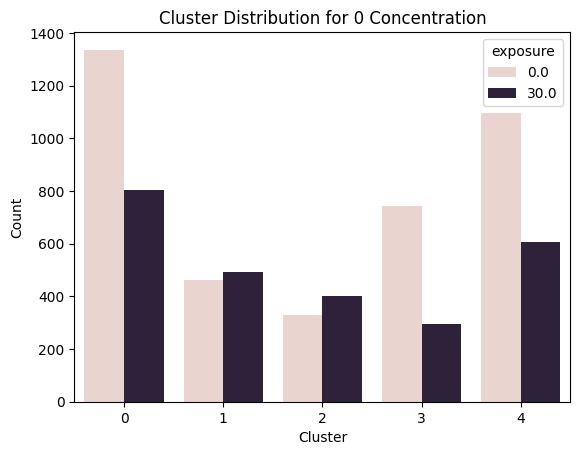

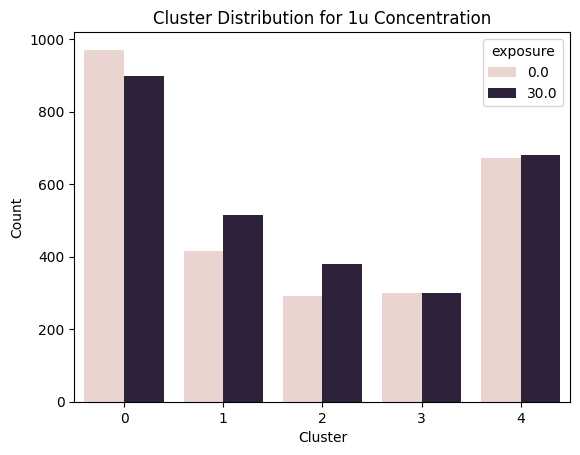

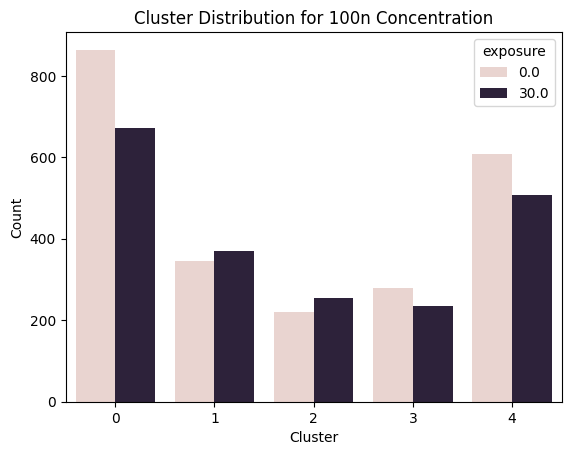

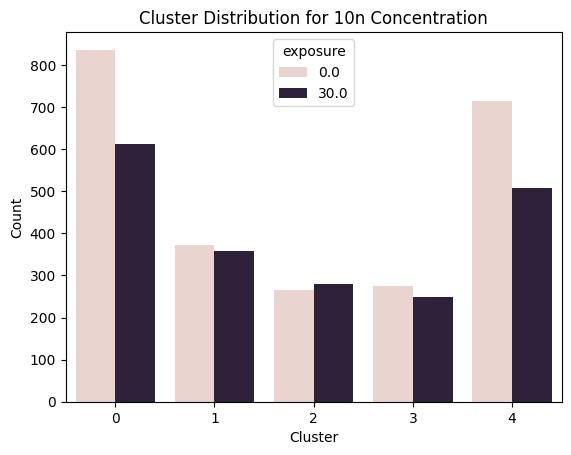

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Distribution of clusters at different time points for each concentration
def plot_cluster_distribution(df):
    for concentration in df['quantity'].unique():
        subset = df[df['quantity'] == concentration]
        sns.countplot(x='Spectral Clustering', hue='exposure', data=subset)
        plt.title(f'Cluster Distribution for {concentration} Concentration')
        plt.xlabel('Cluster')
        plt.ylabel('Count')
        plt.show()

plot_cluster_distribution(df)

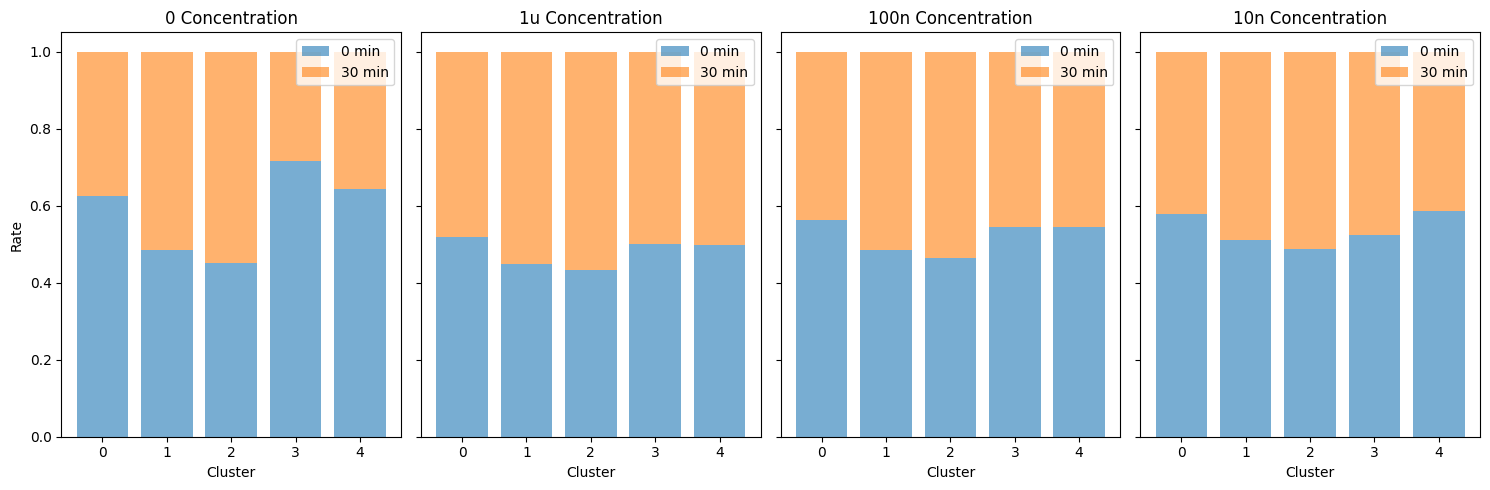

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot rate of elements in each cluster
def plot_cluster_rate(df, num_c):
    # Get unique concentrations
    concentrations = df['quantity'].unique()
    clusters = range(num_c)  # Assuming num_c is the number of clusters

    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(concentrations), figsize=(15, 5), sharey=True)

    for i, concentration in enumerate(concentrations):
        subset = df[df['quantity'] == concentration]
        total = subset.groupby(['Spectral Clustering'])['exposure'].count()

        # Calculate rate (proportion) of elements in each cluster at 0 and 30 minutes
        rate_0 = subset[subset['exposure'] == 0].groupby(['Spectral Clustering'])['exposure'].count() / total
        rate_30 = subset[subset['exposure'] == 30].groupby(['Spectral Clustering'])['exposure'].count() / total

        # Create bar plot for each concentration
        axes[i].bar(clusters, rate_0, label='0 min', alpha=0.6)
        axes[i].bar(clusters, rate_30, bottom=rate_0, label='30 min', alpha=0.6)
        axes[i].set_title(f'{concentration} Concentration')
        axes[i].set_xlabel('Cluster')
        axes[i].set_ylabel('Rate' if i == 0 else '')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

plot_cluster_rate(df, num_c)  # Assuming num_c is the number of clusters


In [14]:
master_df = pd.read_pickle("/home/rodriguez/Documents/my_codes/trajectory/master_08052022.pkl")
motility_param = ['VCL', 'VAP', 'VSL', 'LIN', 'STR', 'WOB', 'BeatCross']
for param in motility_param:
    df[param] = master_df[param]
df.sample()

,name,date,quantity,exposure,tracked_id,centered_traj,cluster_agg,interpolated_traj,fourier_descriptors,Spectral Clustering,VCL,VAP,VSL,LIN,STR,WOB,BeatCross
16519,loki,01062021-3,0,0.0,272.0,"[[8.735294117647072, -5.676470588235297], [6.7...",97,"[[8.735294117647072, -5.676470588235297], [7.3...","[0.45978391356470727, 145.4121051832412, 79.11...",4,115.660904,54.298332,48.16784,0.416457,0.887096,0.469461,25.161291


In [15]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# List of motility parameters
motility_parameters = ['VCL', 'VAP', 'VSL', 'LIN', 'STR', 'WOB', 'BeatCross']

# ANOVA for each motility parameter within each cluster
anova_results = {}
for cluster in df['Spectral Clustering'].unique():
    cluster_data = df[df['Spectral Clustering'] == cluster]
    anova_results_cluster = {}

    for param in motility_parameters:
        model = ols(f'{param} ~ C(quantity) * C(exposure)', data=cluster_data).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        anova_results_cluster[param] = anova_table

    anova_results[cluster] = anova_results_cluster

# Output ANOVA results
for cluster, results in anova_results.items():
    print(f'ANOVA results for Cluster {cluster}:')
    for param, result in results.items():
        print(f'ANOVA for {param}:')
        print(result)
        print()  # Adding a blank line for better readability

ANOVA results for Cluster 4:
ANOVA for VCL:
                               sum_sq      df          F        PR(>F)
C(quantity)              5.129098e+04     3.0  17.691858  2.002216e-11
C(exposure)              7.400648e+04     1.0  76.581435  2.787167e-18
C(quantity):C(exposure)  2.485378e+04     3.0   8.572842  1.123753e-05
Residual                 5.202004e+06  5383.0        NaN           NaN

ANOVA for VAP:
                               sum_sq      df          F        PR(>F)
C(quantity)              1.590717e+04     3.0  15.752676  3.381308e-10
C(exposure)              3.863118e+03     1.0  11.476792  7.097611e-04
C(quantity):C(exposure)  9.581201e+03     3.0   9.488144  3.004951e-06
Residual                 1.811932e+06  5383.0        NaN           NaN

ANOVA for VSL:
                               sum_sq      df         F    PR(>F)
C(quantity)              5.654075e+03     3.0  6.024846  0.000430
C(exposure)              3.814466e+02     1.0  1.219381  0.269532
C(quantity):C(ex

In [16]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from patsy.contrasts import Helmert

# List of motility parameters
motility_parameters = ['VCL', 'VAP', 'VSL', 'LIN', 'STR', 'WOB', 'BeatCross']

# ANOVA with Helmert contrasts for each motility parameter within each cluster
anova_results = {}
for cluster in df['Spectral Clustering'].unique():
    cluster_data = df[df['Spectral Clustering'] == cluster]
    anova_results_cluster = {}

    for param in motility_parameters:
        # Fitting the model with Helmert contrasts
        formula = f'{param} ~ C(quantity, Helmert()) * C(exposure)'
        model = ols(formula, data=cluster_data).fit()

        # Calculating ANOVA table with contrasts
        anova_table = sm.stats.anova_lm(model, typ=2)
        anova_results_cluster[param] = anova_table

    anova_results[cluster] = anova_results_cluster

# Output ANOVA results
for cluster, results in anova_results.items():
    print(f'ANOVA results for Cluster {cluster}:')
    for param, result in results.items():
        print(f'ANOVA for {param} with Helmert Contrasts:')
        print(result)
        print()  # Adding a blank line for better readability


ANOVA results for Cluster 4:
ANOVA for VCL with Helmert Contrasts:
                                          sum_sq      df          F  \
C(quantity, Helmert())              5.129098e+04     3.0  17.691858   
C(exposure)                         7.400648e+04     1.0  76.581435   
C(quantity, Helmert()):C(exposure)  2.485378e+04     3.0   8.572842   
Residual                            5.202004e+06  5383.0        NaN   

                                          PR(>F)  
C(quantity, Helmert())              2.002216e-11  
C(exposure)                         2.787167e-18  
C(quantity, Helmert()):C(exposure)  1.123753e-05  
Residual                                     NaN  

ANOVA for VAP with Helmert Contrasts:
                                          sum_sq      df          F  \
C(quantity, Helmert())              1.590717e+04     3.0  15.752676   
C(exposure)                         3.863118e+03     1.0  11.476792   
C(quantity, Helmert()):C(exposure)  9.581201e+03     3.0   9.488144   